In [150]:
import torch


import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image


In [151]:

class MyDataset(Dataset):
  
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, resize=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            *([transform] if transform else [])
        ]) if resize else transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.float() / 255, label

    def __len__(self):
        return len(self.img_labels)


In [152]:
dataset = MyDataset(annotations_file='labels.csv', img_dir='trainset',resize=(32, 32) )

In [153]:
testset = MyDataset(annotations_file='labels.csv', img_dir='trainset',resize=(32, 32) )

In [154]:
#Hyperparameters

batch_size = 128
val_rate = .2
shuffle_dataset = True
random_seed= 42

In [155]:
dataset_size = len(dataset)
print(dataset_size)

55682


In [156]:
torch.manual_seed(random_seed)
dataset_size = len(dataset)
val_size = int(np.floor(dataset_size * val_rate))

torch.Size([3, 32, 32])


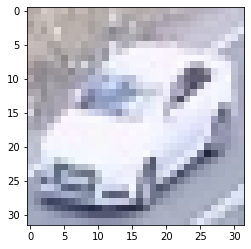

In [157]:

img, label = dataset[44503]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))


In [158]:
indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[val_size:], indices[:val_size]

In [159]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        #Number of batches
        return len(self.dl)

In [160]:
device = get_default_device()
device

device(type='cpu')

In [161]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            sampler=valid_sampler)
train_loader_ = DeviceDataLoader(train_loader, device)
validation_loader_ = DeviceDataLoader(validation_loader, device)


In [162]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score


In [163]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch): #Forward pass
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 

        y_true = [label.item() for label in labels]
        y_pred = [torch.argmax(pred) for pred in out]

        sample_weights = compute_sample_weight(class_weight = "balanced",y = labels)
        acc_balanced = balanced_accuracy_score(y_true = y_true,y_pred = y_pred,sample_weight=sample_weights)
        acc = accuracy(out, labels)        
        return {'loss': loss, 'acc': acc_balanced}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)   

        y_true = [label.item() for label in labels]
        y_pred = [torch.argmax(pred) for pred in out]

        sample_weights = compute_sample_weight(class_weight = "balanced",y = labels)
        acc_balanced = balanced_accuracy_score(y_true = y_true,y_pred = y_pred,sample_weight=sample_weights)

        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc_balanced}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean().item()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean().item()      # Combine accuracies
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'],result['train_acc'] ,result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels): 
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def recall(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [164]:
class FirstCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
        )
        self.flatten= nn.Sequential(
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )
        
        
    def forward(self, xa):
        xb = self.conv1(xa)
        xc = self.conv2(xb)
        xd = self.conv3(xc)
        xz = self.flatten(xd)
        return xz

In [ ]:
model = FirstCnnModel()


In [165]:
def evaluate(model, val_loader):
    model.eval() #sets model.train = False
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    #lr_scheduler =  StepLR(optimizer, 
     #               step_size = 4, # Period of learning rate decay
     #               gamma = 0.5) 
    for epoch in range(epochs):
        # Training Phase 
        model.train() # Sets model.train = True
        train_losses = []
        train_accs = []
        for batch in train_loader: 
            batch = batch
            batch_loss = model.training_step(batch)['loss']
            batch_acc = model.training_step(batch)['acc']
            train_losses.append(batch_loss)
            train_accs.append(batch_acc)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
            #lr_scheduler.step()

        # Validation Phase
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [166]:
opt_funcs = [torch.optim.Adam,torch.optim.SGD,torch.optim.lr_scheduler,]

In [167]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.03

## Model Fitting

In [169]:
history = fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

/Users/ezgi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/ezgi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Epoch [0], train_loss: 0.8937, train_acc: 0.6457, val_loss: 0.8953, val_acc: 0.6422
Epoch [1], train_loss: 0.8882, train_acc: 0.6471, val_loss: 0.8972, val_acc: 0.6422
Epoch [2], train_loss: 0.8890, train_acc: 0.6471, val_loss: 0.8951, val_acc: 0.6422
Epoch [3], train_loss: 0.8881, train_acc: 0.6471, val_loss: 0.8954, val_acc: 0.6422


/Users/ezgi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/ezgi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Epoch [4], train_loss: 0.8864, train_acc: 0.6485, val_loss: 0.8950, val_acc: 0.6422


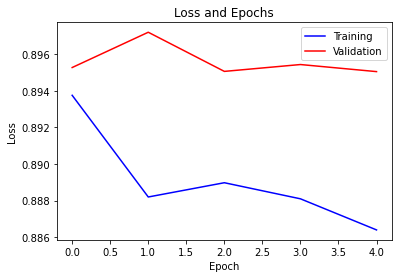

In [170]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss and Epochs')
plt.show()

Label: 1 , Predicted: 2


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


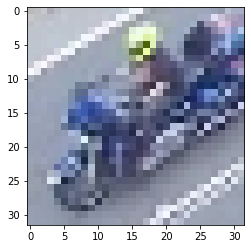

In [171]:
num = 460
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    # Picks index with highest probability 
    _, preds  = torch.max(yb, dim=1)
    # Retrieves the class label
    return int(preds[0])
img,label = testset[num]

plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))